In [51]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import numpy as np
from scipy import stats
import pymc3 as pm
import arviz as az

In [2]:
np.random.seed(123)
trials = 4
theta_real = 0.35 # unknown value in a real experiment
data = stats.bernoulli.rvs(p=theta_real, size=trials)

In [3]:
with pm.Model() as our_first_model:
    theta = pm.Beta('theta', alpha=1., beta=1.)
    y = pm.Bernoulli('y', p=theta, observed=data)
    trace = pm.sample(1000, random_seed=123)

c:\users\95\anaconda3\envs\cogmod\lib\site-packages\pymc3\sampling.py:465: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 25 seconds.


In [4]:
az.summary(trace)

c:\users\95\anaconda3\envs\cogmod\lib\site-packages\arviz\data\io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
theta,0.332,0.18,0.016,0.65,0.005,0.003,1470.0,1470.0,1418.0,1928.0,1.0


c:\users\95\anaconda3\envs\cogmod\lib\site-packages\arviz\data\io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


<AxesSubplot:title={'center':'theta'}>

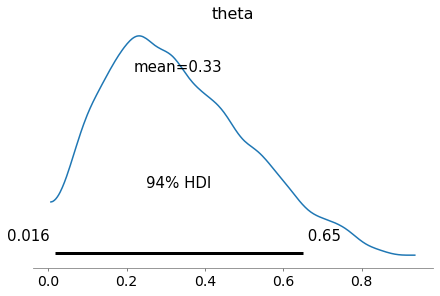

In [5]:
az.plot_posterior(trace)

c:\users\95\anaconda3\envs\cogmod\lib\site-packages\arviz\data\io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


<AxesSubplot:title={'center':'theta'}>

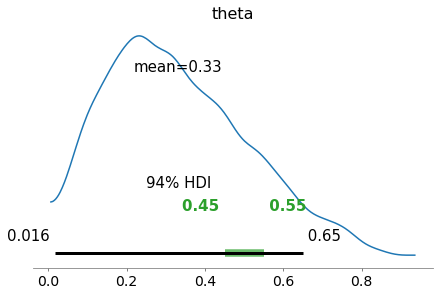

In [6]:
az.plot_posterior(trace, rope=[0.45, .55])

c:\users\95\anaconda3\envs\cogmod\lib\site-packages\arviz\data\io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


<AxesSubplot:title={'center':'theta'}>

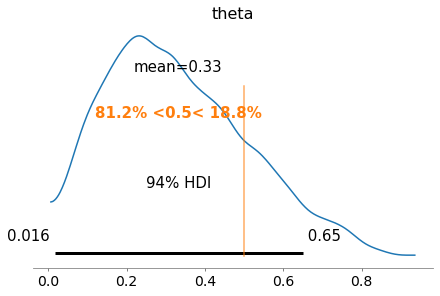

In [8]:
az.plot_posterior(trace, ref_val=0.5)

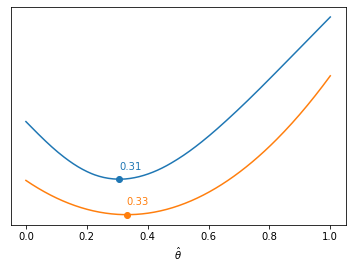

In [8]:
import matplotlib.pyplot as plt
grid = np.linspace(0, 1, 200)
theta_pos = trace['theta']
lossf_a = [np.mean(abs(i - theta_pos)) for i in grid]
lossf_b = [np.mean((i - theta_pos)**2) for i in grid]
for lossf, c in zip([lossf_a, lossf_b], ['C0', 'C1']):
    mini = np.argmin(lossf)
    plt.plot(grid, lossf, c)
    plt.plot(grid[mini], lossf[mini], 'o', color=c)
    plt.annotate('{:.2f}'.format(grid[mini]),
        (grid[mini], lossf[mini] + 0.03), color=c)
    plt.yticks([])
    plt.xlabel(r'$\hat \theta$')

In [9]:
np.mean(theta_pos)
np.median(theta_pos)


0.30799294354430506

Text(0.5, 0, '$\\hat \\theta$')

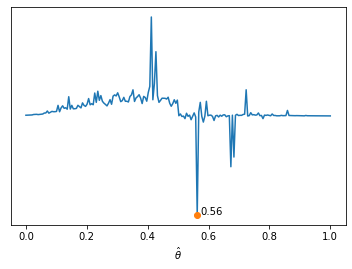

In [13]:
# does not work currently (fix later). 
lossf = []
grid = np.linspace(0, 1, 200)

for i in grid:
    if i < 0.5:
        f = np.mean(np.pi * theta_pos / np.abs(i - theta_pos))
    else:
        f = np.mean(1 / (i - theta_pos))
        
    lossf.append(f)
mini = np.argmin(lossf)
plt.plot(grid, lossf)
plt.plot(grid[mini], lossf[mini], 'o')
plt.annotate('{:.2f}'.format(grid[mini]),
    (grid[mini] + 0.01, lossf[mini] + 0.1))
plt.yticks([])
plt.xlabel(r'$\hat \theta$')

# With actual data

([<matplotlib.axis.YTick at 0x147bc8c3700>], [Text(0, 0, '')])

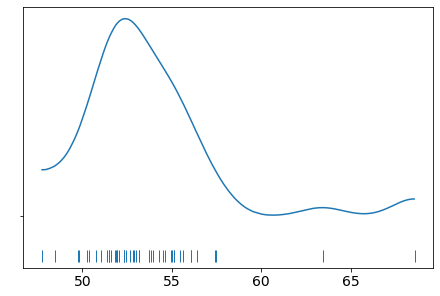

In [16]:
# Chemical shift
# Normal distribution w. outliers
data = np.loadtxt('../data/chemical_shifts.csv')
az.plot_kde(data, rug=True)
plt.yticks([0], alpha=0)

c:\users\95\anaconda3\envs\cogmod\lib\site-packages\pymc3\sampling.py:465: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, μ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 26 seconds.
c:\users\95\anaconda3\envs\cogmod\lib\site-packages\arviz\data\io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<AxesSubplot:title={'center':'μ'}>,
        <AxesSubplot:title={'center':'μ'}>],
       [<AxesSubplot:title={'center':'σ'}>,
        <AxesSubplot:title={'center':'σ'}>]], dtype=object)

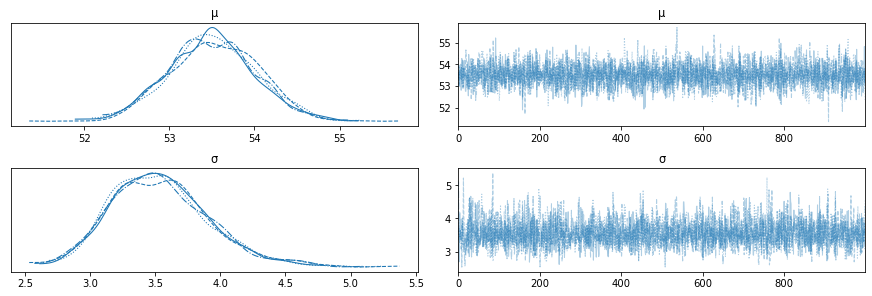

In [18]:
# normal model for this data
with pm.Model() as model_g:
    μ = pm.Uniform('μ', lower=40, upper=70)
    σ = pm.HalfNormal('σ', sd=10)
    y = pm.Normal('y', mu=μ, sd=σ, observed=data)
    trace_g = pm.sample(1000)
az.plot_trace(trace_g)

c:\users\95\anaconda3\envs\cogmod\lib\site-packages\arviz\plots\jointplot.py:144: UserWarning: plot_joint will be deprecated. Please use plot_pair instead.
  warnings.warn("plot_joint will be deprecated. Please use plot_pair instead.")
c:\users\95\anaconda3\envs\cogmod\lib\site-packages\arviz\data\io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([<AxesSubplot:xlabel='μ', ylabel='σ'>, <AxesSubplot:>,
       <AxesSubplot:>], dtype=object)

c:\users\95\anaconda3\envs\cogmod\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  fig.canvas.print_figure(bytes_io, **kw)


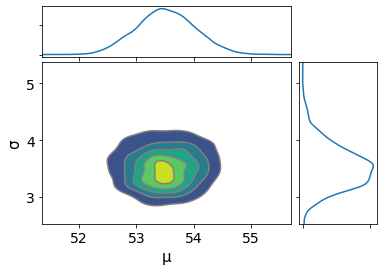

In [20]:
# bi-dimensional posterior:
az.plot_joint(trace_g, kind='kde', fill_last=False)

In [21]:
# summary of the chain. 
az.summary(trace_g)

c:\users\95\anaconda3\envs\cogmod\lib\site-packages\arviz\data\io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
μ,53.508,0.514,52.561,54.483,0.009,0.006,3559.0,3556.0,3562.0,2801.0,1.0
σ,3.538,0.379,2.845,4.225,0.006,0.004,3575.0,3547.0,3591.0,2866.0,1.0


In [22]:
# sample posterior
y_pred_g = pm.sample_posterior_predictive(trace_g, 100, model_g)

c:\users\95\anaconda3\envs\cogmod\lib\site-packages\pymc3\sampling.py:1687: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


c:\users\95\anaconda3\envs\cogmod\lib\site-packages\arviz\data\io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
posterior predictive variable y's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


TypeError: 'AxesSubplot' object is not subscriptable

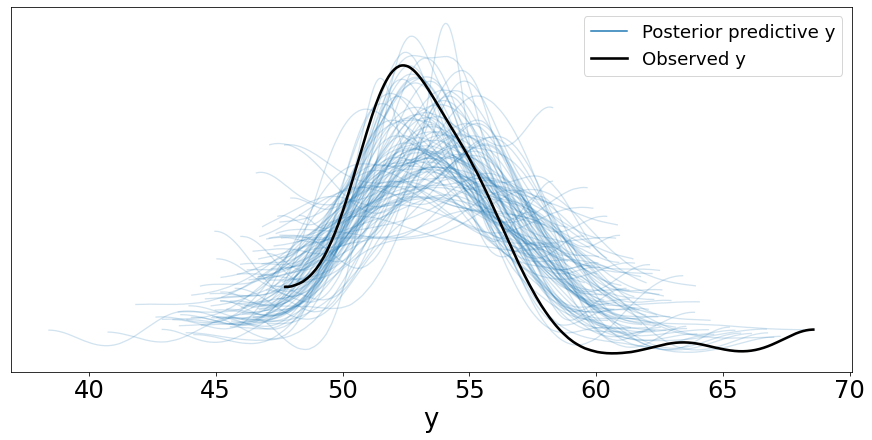

In [23]:
data_ppc = az.from_pymc3(trace=trace_g, posterior_predictive=y_pred_g)
ax = az.plot_ppc(data_ppc, figsize=(12, 6), mean=False)
ax[0].legend(fontsize=15)

# Interrim

In [ ]:
# \theta + tab magic. 
σ = 1
θ = 2
σ + θ

In [ ]:
np.mean(stats.t(loc=0, scale=1, df=100).rvs(100)) # as df --> large, output --> small. 


In [ ]:
plt.figure(figsize=(10, 6))
x_values = np.linspace(-10, 10, 500)
for df in [1, 2, 30]:
    distri = stats.t(df)
    x_pdf = distri.pdf(x_values)
    plt.plot(x_values, x_pdf, label=fr'$\nu = {df}$', lw=3)
x_pdf = stats.norm.pdf(x_values)
plt.plot(x_values, x_pdf, 'k--', label=r'$\nu = \infty$')
plt.xlabel('x')
plt.yticks([])
plt.legend()
plt.xlim(-5, 5)

# More bayesian (re-write with students t). 

c:\users\95\anaconda3\envs\cogmod\lib\site-packages\pymc3\sampling.py:465: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ν, σ, μ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 25 seconds.
c:\users\95\anaconda3\envs\cogmod\lib\site-packages\arviz\data\io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<AxesSubplot:title={'center':'μ'}>,
        <AxesSubplot:title={'center':'μ'}>],
       [<AxesSubplot:title={'center':'σ'}>,
        <AxesSubplot:title={'center':'σ'}>],
       [<AxesSubplot:title={'center':'ν'}>,
        <AxesSubplot:title={'center':'ν'}>]], dtype=object)

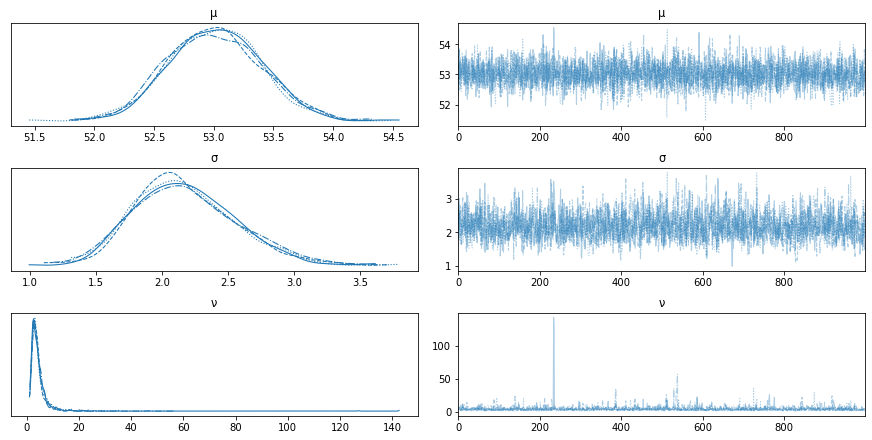

In [24]:
## again, some bayesian stuff missing..
with pm.Model() as model_t:
    μ = pm.Uniform('μ', 40, 75)
    σ = pm.HalfNormal('σ', sd=10)
    ν = pm.Exponential('ν', 1/30)
    y = pm.StudentT('y', mu=μ, sd=σ, nu=ν, observed=data)
    trace_t = pm.sample(1000)
az.plot_trace(trace_t)

c:\users\95\anaconda3\envs\cogmod\lib\site-packages\arviz\data\io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


trace normal: [[<AxesSubplot:title={'center':'μ'}> <AxesSubplot:title={'center':'μ'}>]
 [<AxesSubplot:title={'center':'σ'}> <AxesSubplot:title={'center':'σ'}>]]


c:\users\95\anaconda3\envs\cogmod\lib\site-packages\arviz\data\io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


trace students t: [[<AxesSubplot:title={'center':'μ'}> <AxesSubplot:title={'center':'μ'}>]
 [<AxesSubplot:title={'center':'σ'}> <AxesSubplot:title={'center':'σ'}>]
 [<AxesSubplot:title={'center':'ν'}> <AxesSubplot:title={'center':'ν'}>]]


c:\users\95\anaconda3\envs\cogmod\lib\site-packages\arviz\data\io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


summary normal:      mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
μ  53.508  0.514  52.561   54.483      0.009    0.006    3559.0  3556.0   
σ   3.538  0.379   2.845    4.225      0.006    0.004    3575.0  3547.0   

   ess_bulk  ess_tail  r_hat  
μ    3562.0    2801.0    1.0  
σ    3591.0    2866.0    1.0  


c:\users\95\anaconda3\envs\cogmod\lib\site-packages\arviz\data\io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


summary students t:      mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
μ  53.011  0.387  52.296   53.732      0.007    0.005    3074.0  3074.0   
σ   2.180  0.393   1.511    2.958      0.008    0.006    2144.0  2144.0   
ν   4.448  4.295   1.222    8.838      0.100    0.071    1831.0  1831.0   

   ess_bulk  ess_tail  r_hat  
μ    3057.0    2339.0    1.0  
σ    2107.0    2384.0    1.0  
ν    1916.0    2247.0    1.0  


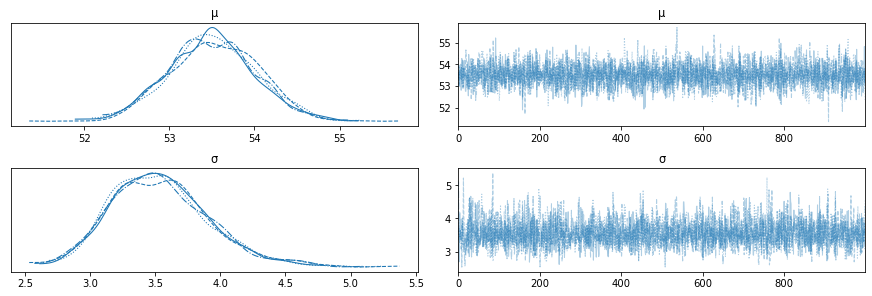

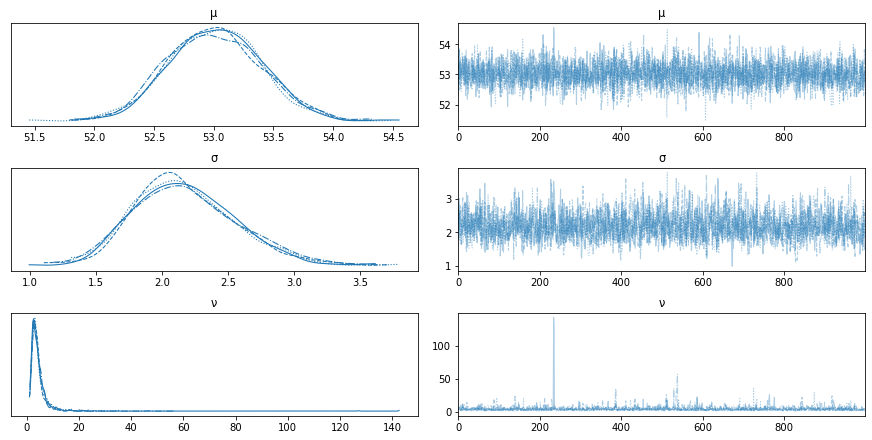

In [25]:
# comparing them 
print(f'trace normal: {az.plot_trace(trace_g)}')
print(f'trace students t: {az.plot_trace(trace_t)}')
print(f'summary normal: {az.summary(trace_g)}')
print(f'summary students t: {az.summary(trace_t)}')

c:\users\95\anaconda3\envs\cogmod\lib\site-packages\pymc3\sampling.py:1687: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


c:\users\95\anaconda3\envs\cogmod\lib\site-packages\arviz\data\io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
posterior predictive variable y's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


(40.0, 70.0)

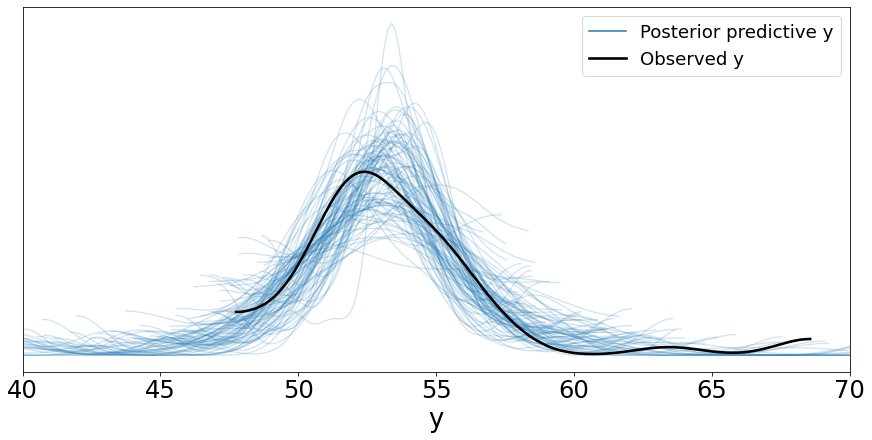

In [27]:
y_ppc_t = pm.sample_posterior_predictive(trace_t, 100, model_t, random_seed=123)
y_pred_t = az.from_pymc3(trace=trace_t, posterior_predictive=y_ppc_t)
az.plot_ppc(y_pred_t, figsize=(12, 6), mean=False)
ax.legend(fontsize=15) #only one subplot so don't index.
plt.xlim(40, 70)

# Tips dataset

In [29]:
import pandas as pd
tips = pd.read_csv('../data/tips.csv')
tips.tail()

,total_bill,tip,sex,smoker,day,time,size
239,29.03,5.92,Male,No,Sat,Dinner,3
240,27.18,2.00,Female,Yes,Sat,Dinner,2
241,22.67,2.00,Male,Yes,Sat,Dinner,2
242,17.82,1.75,Male,No,Sat,Dinner,2
243,18.78,3.00,Female,No,Thur,Dinner,2


<AxesSubplot:xlabel='day', ylabel='tip'>

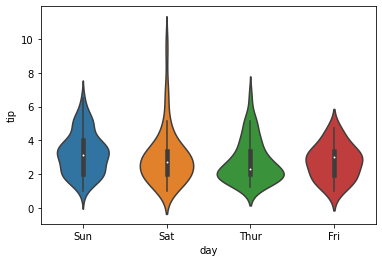

In [31]:
import seaborn as sns
sns.violinplot(x='day', y='tip', data=tips)

In [32]:
# wrangling 
tip = tips['tip'].values
idx = pd.Categorical(tips['day'], categories=['Thur', 'Fri', 'Sat', 'Sun']).codes
groups = len(np.unique(idx))

c:\users\95\anaconda3\envs\cogmod\lib\site-packages\pymc3\sampling.py:465: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, μ]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 35 seconds.
c:\users\95\anaconda3\envs\cogmod\lib\site-packages\arviz\data\io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<AxesSubplot:title={'center':'μ'}>,
        <AxesSubplot:title={'center':'μ'}>],
       [<AxesSubplot:title={'center':'σ'}>,
        <AxesSubplot:title={'center':'σ'}>]], dtype=object)

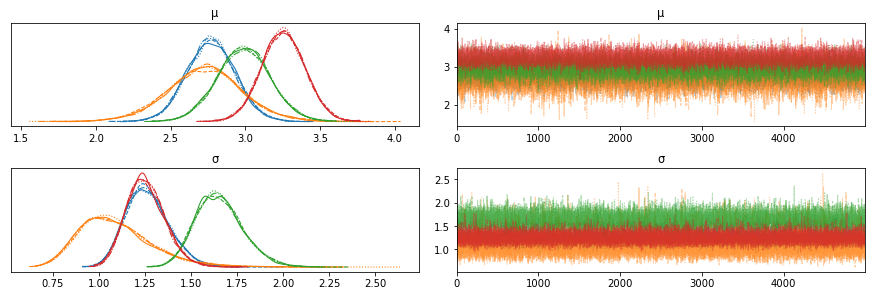

In [33]:
with pm.Model() as comparing_groups:
    μ = pm.Normal('μ', mu=0, sd=10, shape=groups)
    σ = pm.HalfNormal('σ', sd=10, shape=groups)
    y = pm.Normal('y', mu=μ[idx], sd=σ[idx], observed=tip)
    trace_cg = pm.sample(5000)
az.plot_trace(trace_cg)

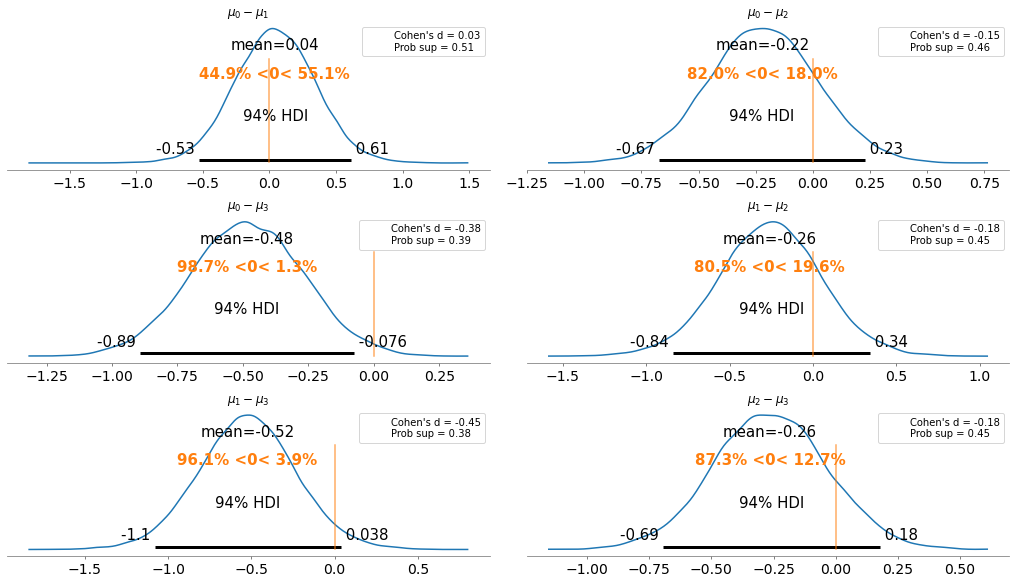

In [34]:
# some wicked plotting
dist = stats.norm()
_, ax = plt.subplots(3, 2, figsize=(14, 8), constrained_layout=True)
comparisons = [(i, j) for i in range(4) for j in range(i+1, 4)]
pos = [(k, l) for k in range(3) for l in (0, 1)]
for (i, j), (k, l) in zip(comparisons, pos):
    means_diff = trace_cg['μ'][:, i] - trace_cg['μ'][:, j]
    d_cohen = (means_diff / np.sqrt((trace_cg['σ'][:, i]**2 + trace_cg['σ'][:, j]**2) / 2)).mean()
    ps = dist.cdf(d_cohen/(2**0.5))
    az.plot_posterior(means_diff, ref_val=0, ax=ax[k, l])
    ax[k, l].set_title(f'$\mu_{i}-\mu_{j}$')
    ax[k, l].plot(
    0, label=f"Cohen's d = {d_cohen:.2f}\nProb sup = {ps:.2f}",
    alpha=0)
    ax[k, l].legend()

# Multilevel Models

In [22]:
N_samples = [30, 30, 30]
G_samples = [18, 3, 3]
group_idx = np.repeat(np.arange(len(N_samples)), N_samples)
data = []
for i in range(0, len(N_samples)):
    data.extend(np.repeat([1, 0], [G_samples[i], N_samples[i]-
G_samples[i]]))

c:\users\95\anaconda3\envs\cogmod\lib\site-packages\pymc3\sampling.py:465: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [θ, κ, μ]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 32 seconds.
c:\users\95\anaconda3\envs\cogmod\lib\site-packages\arviz\data\io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<AxesSubplot:title={'center':'μ'}>,
        <AxesSubplot:title={'center':'μ'}>],
       [<AxesSubplot:title={'center':'κ'}>,
        <AxesSubplot:title={'center':'κ'}>],
       [<AxesSubplot:title={'center':'θ'}>,
        <AxesSubplot:title={'center':'θ'}>]], dtype=object)

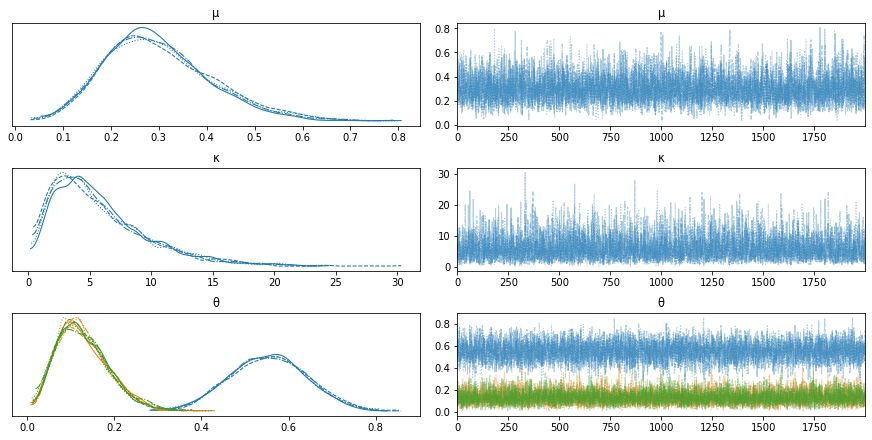

In [23]:
with pm.Model() as model_h:
    μ = pm.Beta('μ', 1., 1.)
    κ = pm.HalfNormal('κ', 10)
    θ = pm.Beta('θ', alpha=μ*κ, beta=(1.0-μ)*κ, shape=len(N_samples))
    y = pm.Bernoulli('y', p=θ[group_idx], observed=data)
    trace_h = pm.sample(2000)
az.plot_trace(trace_h)

In [24]:
gmix = az.summary(trace_h)

c:\users\95\anaconda3\envs\cogmod\lib\site-packages\arviz\data\io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


In [26]:
print(f'g18: {g18}') #high mean
print(f'g3: {g3}') #low mean
print(f'gmix: {gmix}') #shrinkage. 

g18:         mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
μ      0.585  0.097   0.395    0.761      0.001    0.001    4987.0  4941.0   
κ     12.240  6.279   1.603   23.776      0.081    0.057    6074.0  6074.0   
θ[0]   0.595  0.079   0.449    0.742      0.001    0.001    5303.0  5269.0   
θ[1]   0.597  0.080   0.452    0.752      0.001    0.001    5373.0  5353.0   
θ[2]   0.597  0.080   0.443    0.740      0.001    0.001    6039.0  5963.0   

      ess_bulk  ess_tail  r_hat  
μ       4959.0    5048.0    1.0  
κ       5625.0    4371.0    1.0  
θ[0]    5294.0    5581.0    1.0  
θ[1]    5367.0    5226.0    1.0  
θ[2]    6015.0    5121.0    1.0  
g3:         mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
μ      0.163  0.076   0.038    0.296      0.001    0.001    4209.0  4061.0   
κ     11.766  6.282   1.088   22.937      0.085    0.060    5459.0  5459.0   
θ[0]   0.114  0.051   0.029    0.207      0.001    0.000    5965.0  5965.0   
θ[1]  

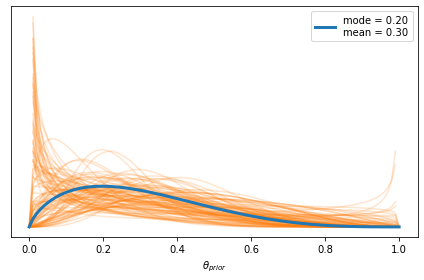

In [27]:
# looking at the estimated prior
x = np.linspace(0, 1, 100)
for i in np.random.randint(0, len(trace_h), size=100):
    u = trace_h['μ'][i]
    k = trace_h['κ'][i]
    pdf = stats.beta(u*k, (1.0-u)*k).pdf(x)
    plt.plot(x, pdf, 'C1', alpha=0.2)
u_mean = trace_h['μ'].mean()
k_mean = trace_h['κ'].mean()
dist = stats.beta(u_mean*k_mean, (1.0-u_mean)*k_mean)
pdf = dist.pdf(x)
mode = x[np.argmax(pdf)]
mean = dist.moment(1)
plt.plot(x, pdf, lw=3, label=f'mode = {mode:.2f}\nmean = {mean:.2f}')
plt.yticks([])
plt.legend()
plt.xlabel('$θ_{prior}$')
plt.tight_layout()

# Hierarchical model example 2

In [35]:
cs_data = pd.read_csv('../data/chemical_shifts_theo_exp.csv')
diff = cs_data.theo.values - cs_data.exp.values
idx = pd.Categorical(cs_data['aa']).codes
groups = len(np.unique(idx))

In [36]:
# non-hierarchical
with pm.Model() as cs_nh:
    μ = pm.Normal('μ', mu=0, sd=10, shape=groups)
    σ = pm.HalfNormal('σ', sd=10, shape=groups)
    y = pm.Normal('y', mu=μ[idx], sd=σ[idx], observed=diff)
    trace_cs_nh = pm.sample(1000)

c:\users\95\anaconda3\envs\cogmod\lib\site-packages\pymc3\sampling.py:465: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, μ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 30 seconds.


In [39]:
# hierarchical
with pm.Model() as cs_h:
    # hyper_priors
    μ_μ = pm.Normal('μ_μ', mu=0, sd=10)
    σ_μ = pm.HalfNormal('σ_μ', 10)
    # priors
    μ = pm.Normal('μ', mu=μ_μ, sd=σ_μ, shape=groups)
    σ = pm.HalfNormal('σ', sd=10, shape=groups)
    y = pm.Normal('y', mu=μ[idx], sd=σ[idx], observed=diff)
    trace_cs_h = pm.sample(1000)

c:\users\95\anaconda3\envs\cogmod\lib\site-packages\pymc3\sampling.py:465: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, μ, σ_μ, μ_μ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 39 seconds.


c:\users\95\anaconda3\envs\cogmod\lib\site-packages\arviz\data\io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


ValueError: not enough values to unpack (expected 2, got 1)

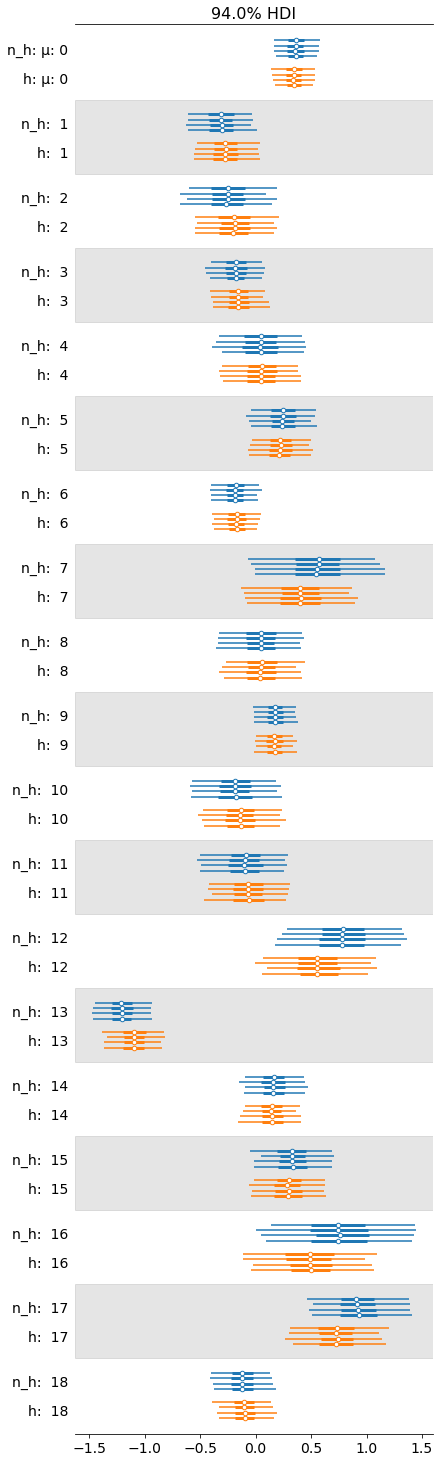

In [40]:
_, axes = az.plot_forest([trace_cs_nh, trace_cs_h],
model_names=['n_h', 'h'],
var_names='μ', combined=False, colors='cycle')
y_lims = axes[0].get_ylim()
axes[0].vlines(trace_cs_h['μ_μ'].mean(), *y_lims)

# Exercises

## Exercise 1

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 22 seconds.


array([[<AxesSubplot:title={'center':'theta'}>,
        <AxesSubplot:title={'center':'theta'}>]], dtype=object)

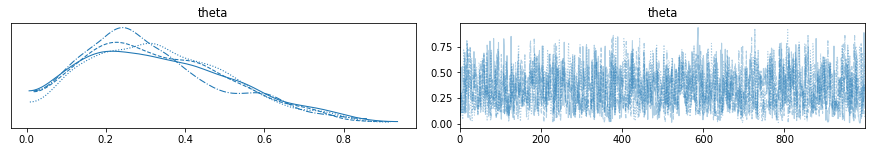

In [52]:
# 1 - the model from before (22 seconds). 
np.random.seed(123)
trials = 4
theta_real = 0.35 # unknown value in a real experiment
data = stats.bernoulli.rvs(p=theta_real, size=trials)

# is this the data he is talking about?
#beta_params = [(1, 1), (20, 20), (1, 4)]

with pm.Model() as our_first_model:
    theta = pm.Beta('theta', alpha=1., beta=1.)
    y = pm.Bernoulli('y', p=theta, observed=data)
    trace_baseline = pm.sample(1000, random_seed=123)
az.plot_trace(trace_baseline)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 25 seconds.
The acceptance probability does not match the target. It is 0.890027446114615, but should be close to 0.8. Try to increase the number of tuning steps.


array([[<AxesSubplot:title={'center':'theta'}>,
        <AxesSubplot:title={'center':'theta'}>]], dtype=object)

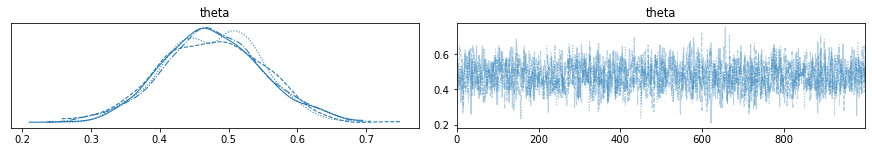

In [53]:
# changing the priors based on values from earlier chapter. 
# error message & 25 seconds. too strict prior I believe. 
np.random.seed(123)

# is this the data he is talking about?
with pm.Model() as our_first_model:
    theta = pm.Beta('theta', alpha=20, beta=20)
    y = pm.Bernoulli('y', p=theta, observed=data)
    trace_normal = pm.sample(1000, random_seed=123)
az.plot_trace(trace_normal) 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 24 seconds.


array([[<AxesSubplot:title={'center':'theta'}>,
        <AxesSubplot:title={'center':'theta'}>]], dtype=object)

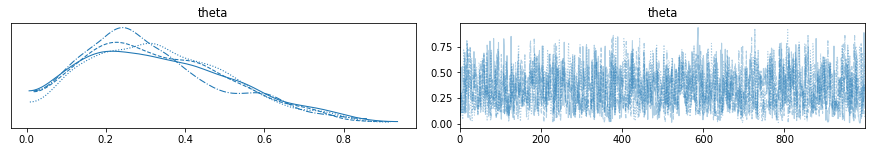

In [54]:
# uniform prior 
# 24 seconds. Actually pretty close to the estimate from our beta model (likelihood is strong). 
with pm.Model() as our_first_model:
    theta = pm.Uniform('theta', lower = 0, upper = 1)
    y = pm.Bernoulli('y', p=theta, observed=data)
    trace_unif = pm.sample(1000, random_seed=123)
az.plot_trace(trace_unif) 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 27 seconds.
There were 141 divergences after tuning. Increase `target_accept` or reparameterize.
There were 154 divergences after tuning. Increase `target_accept` or reparameterize.
There were 139 divergences after tuning. Increase `target_accept` or reparameterize.
There were 146 divergences after tuning. Increase `target_accept` or reparameterize.


array([[<AxesSubplot:title={'center':'theta'}>,
        <AxesSubplot:title={'center':'theta'}>]], dtype=object)

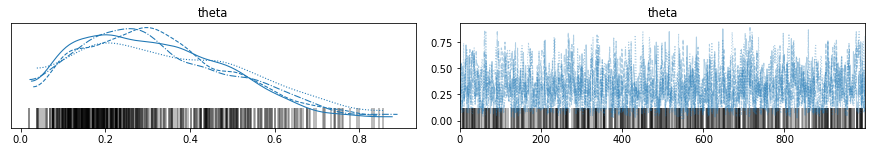

In [55]:
# uniform with larger interval (should be worse of course). 
# divergence + 27 seconds. 
with pm.Model() as our_first_model:
    theta = pm.Uniform('theta', lower = -1, upper = 2)
    y = pm.Bernoulli('y', p=theta, observed=data)
    trace_unif2 = pm.sample(1000, random_seed=123)
az.plot_trace(trace_unif2) 

# Question 2 (coal mining)

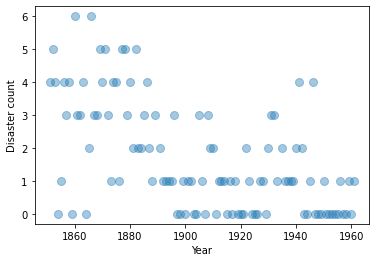

In [56]:
#https://docs.pymc.io/notebooks/getting_started.html
# fmt: off
disaster_data = pd.Series(
    [4, 5, 4, 0, 1, 4, 3, 4, 0, 6, 3, 3, 4, 0, 2, 6,
    3, 3, 5, 4, 5, 3, 1, 4, 4, 1, 5, 5, 3, 4, 2, 5,
    2, 2, 3, 4, 2, 1, 3, np.nan, 2, 1, 1, 1, 1, 3, 0, 0,
    1, 0, 1, 1, 0, 0, 3, 1, 0, 3, 2, 2, 0, 1, 1, 1,
    0, 1, 0, 1, 0, 0, 0, 2, 1, 0, 0, 0, 1, 1, 0, 2,
    3, 3, 1, np.nan, 2, 1, 1, 1, 1, 2, 4, 2, 0, 0, 1, 4,
    0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1]
)
# fmt: on
years = np.arange(1851, 1962)

plt.plot(years, disaster_data, "o", markersize=8, alpha=0.4)
plt.ylabel("Disaster count")
plt.xlabel("Year");



In [57]:
# implement model (just copied). 
with pm.Model() as disaster_model:

    switchpoint = pm.DiscreteUniform(
        "switchpoint", lower=years.min(), upper=years.max(), testval=1900
    )

    # Priors for pre- and post-switch rates number of disasters
    early_rate = pm.Exponential("early_rate", 1.0)
    late_rate = pm.Exponential("late_rate", 1.0)

    # Allocate appropriate Poisson rates to years before and after current
    rate = pm.math.switch(switchpoint >= years, early_rate, late_rate)

    disasters = pm.Poisson("disasters", rate, observed=disaster_data)

c:\users\95\anaconda3\envs\cogmod\lib\site-packages\pymc3\model.py:1739: ImputationWarning: Data in disasters contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [disasters_missing]
>>Metropolis: [switchpoint]
>NUTS: [late_rate, early_rate]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 50 seconds.
The number of effective samples is smaller than 10% for some parameters.


array([[<AxesSubplot:title={'center':'switchpoint'}>,
        <AxesSubplot:title={'center':'switchpoint'}>],
       [<AxesSubplot:title={'center':'disasters_missing'}>,
        <AxesSubplot:title={'center':'disasters_missing'}>],
       [<AxesSubplot:title={'center':'early_rate'}>,
        <AxesSubplot:title={'center':'early_rate'}>],
       [<AxesSubplot:title={'center':'late_rate'}>,
        <AxesSubplot:title={'center':'late_rate'}>]], dtype=object)

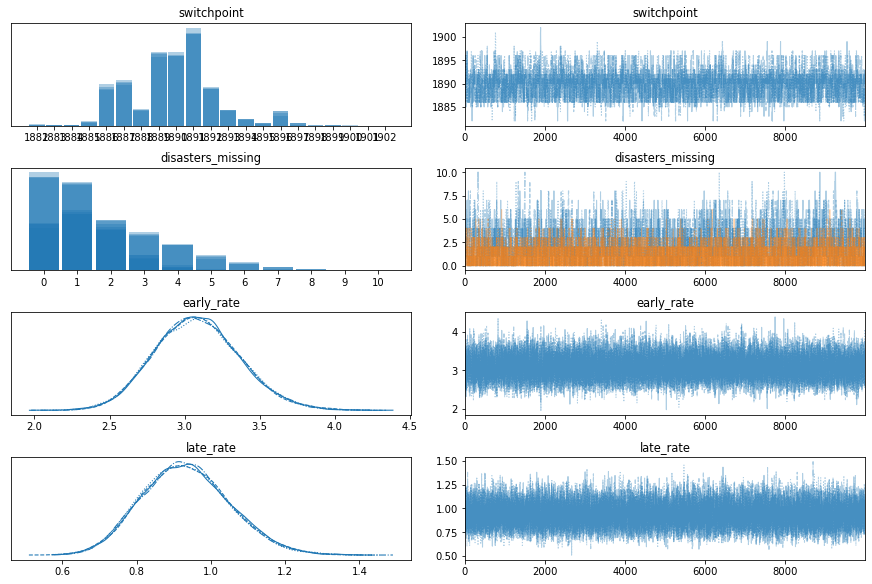

In [58]:
with disaster_model:
    switch_trace = pm.sample(10000, return_inferencedata=False)
az.plot_trace(switch_trace)

In [69]:
az.summary(switch_trace, kind="stats") #makes sense, could be a bit before I guess. 

,mean,sd,hdi_3%,hdi_97%
switchpoint,1889.830,2.442,1886.000,1894.000
disasters_missing[0],2.136,1.771,0.000,5.000
disasters_missing[1],0.949,0.986,0.000,3.000
early_rate,3.085,0.285,2.560,3.624
late_rate,0.933,0.118,0.716,1.155


# Question 3 (model G)

([<matplotlib.axis.YTick at 0x147befc8130>], [Text(0, 0, '')])

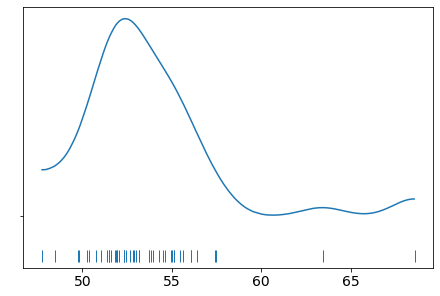

In [73]:
# get the data in here again. 
data = np.loadtxt('../data/chemical_shifts.csv')
az.plot_kde(data, rug=True)
plt.yticks([0], alpha=0)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, μ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 27 seconds.


array([[<AxesSubplot:title={'center':'μ'}>,
        <AxesSubplot:title={'center':'μ'}>],
       [<AxesSubplot:title={'center':'σ'}>,
        <AxesSubplot:title={'center':'σ'}>]], dtype=object)

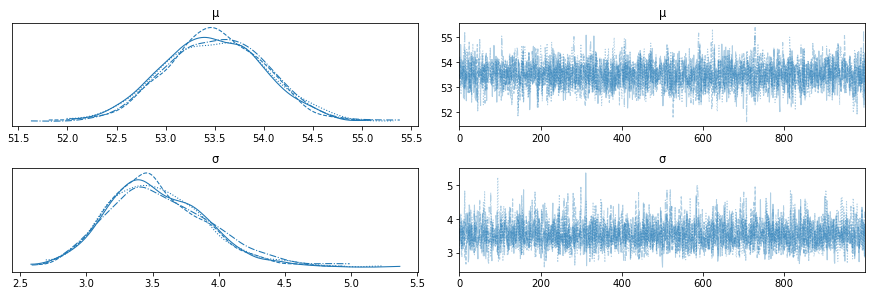

In [74]:
# the original model
with pm.Model() as model_g:
    μ = pm.Uniform('μ', lower=40, upper=70)
    σ = pm.HalfNormal('σ', sd=10)
    y = pm.Normal('y', mu=μ, sd=σ, observed=data)
    trace_g = pm.sample(1000)
az.plot_trace(trace_g)

In [82]:
# find empirical mean 
d_mean = data.mean()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, μ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 26 seconds.


array([[<AxesSubplot:title={'center':'μ'}>,
        <AxesSubplot:title={'center':'μ'}>],
       [<AxesSubplot:title={'center':'σ'}>,
        <AxesSubplot:title={'center':'σ'}>]], dtype=object)

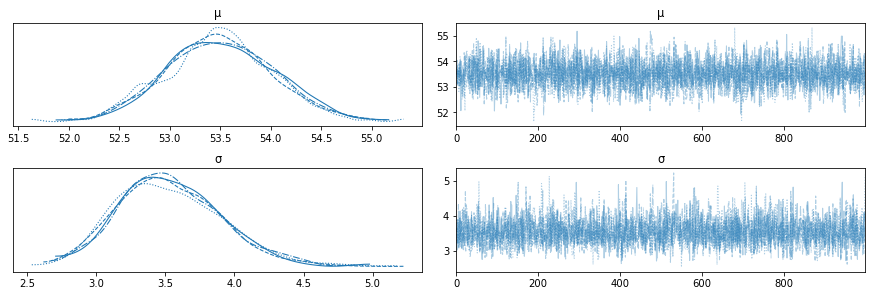

In [84]:
# new model g. (sd = 20). 
# most data prob. within 2*20 (40) on each side (reserving almost all prob. mass to within [0, 100])
with pm.Model() as model_g:
    μ = pm.Normal('μ', mu = d_mean, sd = 20)
    σ = pm.HalfNormal('σ', sd=10)
    y = pm.Normal('y', mu=μ, sd=σ, observed=data)
    trace_g2 = pm.sample(1000)
az.plot_trace(trace_g2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, μ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 24 seconds.


array([[<AxesSubplot:title={'center':'μ'}>,
        <AxesSubplot:title={'center':'μ'}>],
       [<AxesSubplot:title={'center':'σ'}>,
        <AxesSubplot:title={'center':'σ'}>]], dtype=object)

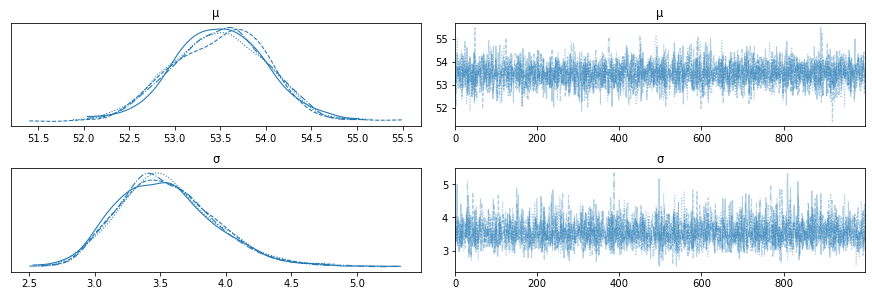

In [85]:
# new model g. (sd = 5). 
# skeptical model. 
# of course it should recover the value well when we basically hack it by setting mu = d_mean??
with pm.Model() as model_g:
    μ = pm.Normal('μ', mu = d_mean, sd = 20)
    σ = pm.HalfNormal('σ', sd=10)
    y = pm.Normal('y', mu=μ, sd=σ, observed=data)
    trace_g3 = pm.sample(1000)
az.plot_trace(trace_g3)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, μ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 25 seconds.
The acceptance probability does not match the target. It is 0.8850482620189832, but should be close to 0.8. Try to increase the number of tuning steps.


array([[<AxesSubplot:title={'center':'μ'}>,
        <AxesSubplot:title={'center':'μ'}>],
       [<AxesSubplot:title={'center':'σ'}>,
        <AxesSubplot:title={'center':'σ'}>]], dtype=object)

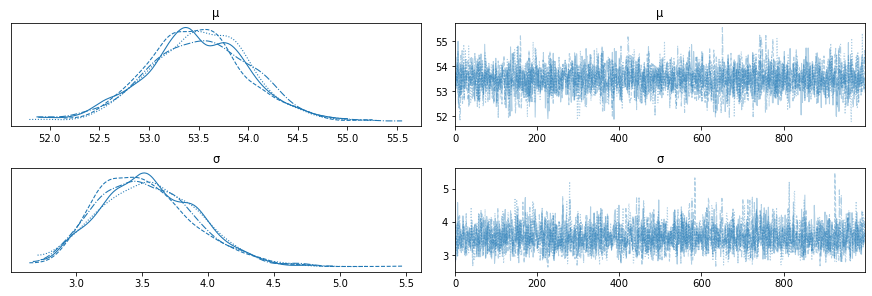

In [86]:
# new model g. (sd = 1). 
# super skeptical model. 
# now becomes a bit jiggly..
with pm.Model() as model_g:
    μ = pm.Normal('μ', mu = d_mean, sd = 20)
    σ = pm.HalfNormal('σ', sd=10)
    y = pm.Normal('y', mu=μ, sd=σ, observed=data)
    trace_g4 = pm.sample(1000)
az.plot_trace(trace_g4)

In [87]:
# I don't really think it is a big deal that it assigns probability mass to values that basically do not make sense. 
# I guess it is a bit weird when values are not logically possible (e.g. negative sd which by definition is positive). 
# This is actually corrected for automatically in brms. 
# could just use half-normal as he discusses in the chapter. 

# Question 4

([<matplotlib.axis.YTick at 0x147ca98f100>], [Text(0, 0, '')])

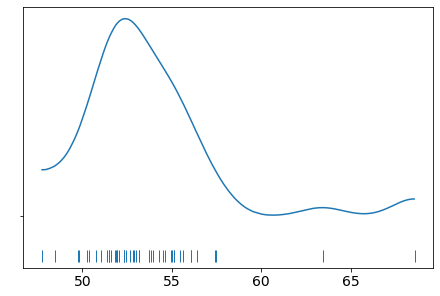

In [88]:
# load the data again. 
data = np.loadtxt('../data/chemical_shifts.csv')
az.plot_kde(data, rug=True)
plt.yticks([0], alpha=0)

In [111]:
# empirical mean with outliers.
mean1 = data.mean()

# mean without outliers (more than two standard deviations away from the mean). 
import statistics 
data_clean = [d for d in data if d < (np.mean(data) + 2*np.std(data)) and d > (np.mean(data) - 2*np.std(data))] 
mean2 = statistics.mean(data_clean)

# print it
print(f'mean w. outliers: {round(mean1, 3)}')
print(f'mean no outliers: {round(mean2, 3)}')

mean w. outliers: 53.496
mean no outliers: 52.953


In [112]:
# the normal model (very close to the mean for outlier data). 
with pm.Model() as model_g:
    μ = pm.Uniform('μ', lower=40, upper=70)
    σ = pm.HalfNormal('σ', sd=10)
    y = pm.Normal('y', mu=μ, sd=σ, observed=data)
    trace_normal = pm.sample(1000)
az.summary(trace_g)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, μ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 24 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
μ,53.518,0.507,52.549,54.448,0.009,0.006,3487.0,3485.0,3494.0,2771.0,1.0
σ,3.539,0.375,2.909,4.287,0.007,0.005,3063.0,2963.0,3202.0,2770.0,1.0


In [117]:
# the student t model (very close to the mean without outliers.)
with pm.Model() as model_t:
    μ = pm.Uniform('μ', 40, 75)
    σ = pm.HalfNormal('σ', sd=10)
    ν = pm.Exponential('ν', 1/30)
    y = pm.StudentT('y', mu=μ, sd=σ, nu=ν, observed=data)
    trace_t = pm.sample(1000)
az.summary(trace_t)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ν, σ, μ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 26 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
μ,53.014,0.395,52.297,53.776,0.007,0.005,2877.0,2872.0,2908.0,2316.0,1.0
σ,2.195,0.410,1.445,2.949,0.010,0.007,1721.0,1685.0,1759.0,2054.0,1.0
ν,4.637,3.811,1.129,9.547,0.105,0.075,1309.0,1309.0,1754.0,1523.0,1.0


In [149]:
# adding 10 outliers to the data (between 2 and 4 SD from mean). 
# first we define lower and upper
lower = np.mean(data) + 2 * np.std(data)
upper = np.mean(data) + 4 * np.std(data)

# then we generate outliers
import random as random
outliers = [round(random.uniform(lower, upper),2) for i in range(10)]

# then we add them to the data
d_outlier = np.append (data, outliers)
d_outlier

array([51.06, 55.12, 53.73, 50.24, 52.05, 56.4 , 48.45, 52.34, 55.65,
       51.49, 51.86, 63.43, 53.  , 56.09, 51.93, 52.31, 52.33, 57.48,
       57.44, 55.14, 53.93, 54.62, 56.09, 68.58, 51.36, 55.47, 50.73,
       51.94, 54.95, 50.39, 52.91, 51.5 , 52.68, 47.72, 49.73, 51.82,
       54.99, 52.84, 53.19, 54.52, 51.46, 53.73, 51.61, 49.81, 52.42,
       54.3 , 53.84, 53.16, 60.39, 65.64, 66.1 , 61.41, 63.36, 61.45,
       65.7 , 61.07, 65.23, 61.38])

In [152]:
# rinse and repeat. 
# calculate mean with outliers. 
mean1 = np.mean(d_outlier) 

# calculate mean wtihout outliers
data_clean = [d for d in d_outlier if d < (np.mean(d_outlier) + 2*np.std(d_outlier)) and d > (np.mean(d_outlier) - 2*np.std(d_outlier))] 
mean2 = statistics.mean(data_clean)

# print these
print(f'mean w. outliers: {round(mean1, 3)}')
print(f'mean no outliers: {round(mean2, 3)}') #notice that this has also jumped.. i.e. they are not really outliers anymore..

mean w. outliers: 55.165
mean no outliers: 54.119


In [157]:
# the normal model (again, close to the w. outlier mean). 
with pm.Model() as model_g:
    μ = pm.Uniform('μ', lower=40, upper=70)
    σ = pm.HalfNormal('σ', sd=10)
    y = pm.Normal('y', mu=μ, sd=σ, observed=d_outlier)
    trace_normal = pm.sample(1000)
az.summary(trace_normal)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, μ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 26 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
μ,55.155,0.661,53.929,56.390,0.011,0.008,3487.0,3487.0,3483.0,2776.0,1.0
σ,5.033,0.489,4.185,5.984,0.009,0.006,2859.0,2839.0,2858.0,2617.0,1.0


In [156]:
# the student t model (again close to the no-outlier data). 
with pm.Model() as model_t:
    μ = pm.Uniform('μ', 40, 75)
    σ = pm.HalfNormal('σ', sd=10)
    ν = pm.Exponential('ν', 1/30)
    y = pm.StudentT('y', mu=μ, sd=σ, nu=ν, observed=d_outlier)
    trace_t = pm.sample(1000)
az.summary(trace_t)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ν, σ, μ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 27 seconds.
There were 49 divergences after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.
There were 82 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6554638375519094, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
μ,54.532,0.841,52.910,55.967,0.061,0.044,187.0,187.0,190.0,317.0,1.02
σ,4.221,0.959,2.289,5.805,0.097,0.069,99.0,99.0,122.0,56.0,1.03
ν,22.744,27.597,0.920,73.878,1.144,0.809,582.0,582.0,119.0,101.0,1.04


# Q5 (robust tips)

In [160]:
# the data
import pandas as pd
tips = pd.read_csv('../data/tips.csv')
tips.tail()

# wrangling 
tip = tips['tip'].values
idx = pd.Categorical(tips['day'], categories=['Thur', 'Fri', 'Sat', 'Sun']).codes
groups = len(np.unique(idx))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, μ]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 41 seconds.


array([[<AxesSubplot:title={'center':'μ'}>,
        <AxesSubplot:title={'center':'μ'}>],
       [<AxesSubplot:title={'center':'σ'}>,
        <AxesSubplot:title={'center':'σ'}>]], dtype=object)

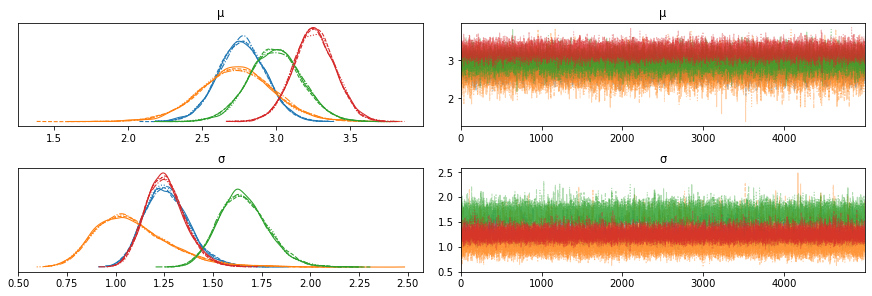

In [161]:
# earlier model
with pm.Model() as comparing_groups:
    μ = pm.Normal('μ', mu=0, sd=10, shape=groups)
    σ = pm.HalfNormal('σ', sd=10, shape=groups)
    y = pm.Normal('y', mu=μ[idx], sd=σ[idx], observed=tip)
    trace_cg = pm.sample(5000)
az.plot_trace(trace_cg)

In [177]:
# hierarchical model
# does not really work.
# probably parameterized it wrong. 
with pm.Model() as norm_hierarchical:
    
    # more tuning. 
    tune = 2000
    
    # hyper_priors
    μ_μ = pm.Normal('μ_μ', mu = 3, sd = 5)
    σ_μ = pm.HalfNormal('σ_μ', 5)
    v_μ = pm.Exponential('v_μ', 1)
    
    # priors
    μ = pm.Normal('μ', mu=μ_μ, sd=σ_μ, shape=groups)
    σ = pm.HalfNormal('σ', sd=5, shape=groups)
    ν = pm.Exponential('ν', v_μ, shape=groups)
    y = pm.StudentT('y', mu=μ[idx], sd=σ[idx], nu=ν[idx], observed=tip)
    norm_hierarchical = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ν, σ, μ, v_μ, σ_μ, μ_μ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 36 seconds.
There were 46 divergences after tuning. Increase `target_accept` or reparameterize.
There were 56 divergences after tuning. Increase `target_accept` or reparameterize.
There were 106 divergences after tuning. Increase `target_accept` or reparameterize.
There were 40 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


array([[<AxesSubplot:title={'center':'μ_μ'}>,
        <AxesSubplot:title={'center':'μ_μ'}>],
       [<AxesSubplot:title={'center':'μ'}>,
        <AxesSubplot:title={'center':'μ'}>],
       [<AxesSubplot:title={'center':'σ_μ'}>,
        <AxesSubplot:title={'center':'σ_μ'}>],
       [<AxesSubplot:title={'center':'v_μ'}>,
        <AxesSubplot:title={'center':'v_μ'}>],
       [<AxesSubplot:title={'center':'σ'}>,
        <AxesSubplot:title={'center':'σ'}>],
       [<AxesSubplot:title={'center':'ν'}>,
        <AxesSubplot:title={'center':'ν'}>]], dtype=object)

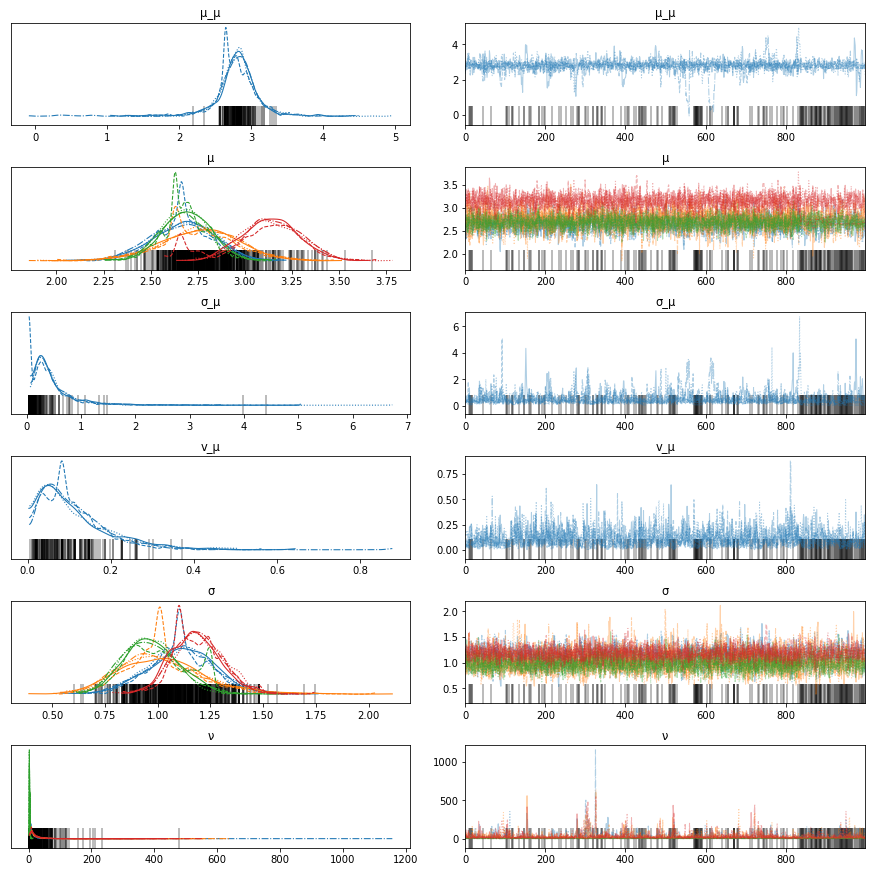

In [178]:
az.plot_trace(norm_hierarchical)

In [183]:
# only v as hyper (what is wrong?)
with pm.Model() as v_hyper:
    
    # hyper_priors
    μ_μ = pm.Normal('μ_μ', mu = 3, sd = 5)
    σ_μ = pm.HalfNormal('σ_μ', 5)
    v_μ = pm.Exponential('v_μ', 1)
    
    # priors
    μ = pm.Normal('μ', mu=μ_μ, sd=σ_μ, shape=groups)
    σ = pm.HalfNormal('σ', sd=5, shape=groups)
    y = pm.StudentT('y', mu=μ[idx], sd=σ[idx], nu=ν_μ, observed=tip)
    v_hyper = pm.sample(1000)

NameError: name 'ν_u' is not defined

In [186]:
# same issue
with pm.Model() as v_prior:
    
    # hyper_priors
    μ_μ = pm.Normal('μ_μ', mu = 3, sd = 5)
    σ_μ = pm.HalfNormal('σ_μ', 5)
    
    # priors
    μ = pm.Normal('μ', mu=μ_μ, sd=σ_μ, shape=groups)
    σ = pm.HalfNormal('σ', sd=5, shape=groups)
    ν = pm.Exponential('ν', 1, shape=groups)
    y = pm.StudentT('y', mu=μ[idx], sd=σ[idx], nu=v[idx], observed=tip)
    v_prior = pm.sample(1000)

NameError: name 'v' is not defined